In [1]:
%run model.ipynb

/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
model.ipynb:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "metadata": {},
model.ipynb:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "import pandas as pd\n",


The notes are: C4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
import sys
sys.path.append('../preparations/')

In [3]:
import x01_generate_notes
import x02_generate_midi
import x03_generate_wav
import x04_generate_wav_processed
import x05_generate_spectrogram
import x06_generate_label


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



In [4]:
!mkdir notes
!mkdir midi
!mkdir wav
!mkdir wav_processed
!mkdir spectrogram
!mkdir label
!rm ./notes/*
!rm ./midi/*
!rm ./wav/*
!rm ./wav_processed/*
!rm ./spectrogram/*
!rm ./label/*

mkdir: notes: File exists
mkdir: midi: File exists
mkdir: wav: File exists
mkdir: wav_processed: File exists
mkdir: spectrogram: File exists
mkdir: label: File exists
rm: ./notes/*: No such file or directory
rm: ./midi/*: No such file or directory
rm: ./wav/*: No such file or directory
rm: ./wav_processed/*: No such file or directory
rm: ./label/*: No such file or directory


In [5]:
import glob
files = glob.glob('../*.wav')
print(len(files))
for filename in files:
    print(filename)
    x05_generate_spectrogram.generate_spectrogram(filename)

1
../closer.wav


In [6]:
import soundfile as sf
import sounddevice as sd

audio, sr = sf.read(files[0])

sd.play(audio, samplerate=sr)

In [7]:
!ls ./spectrogram/

closer.npy


In [8]:
!ls ./notes/
!ls ./midi/
!ls ./wav/
!ls ./wav_processed/
!ls ./spectrogram/
!ls ./label/

closer.npy


In [9]:
import glob
import matplotlib.pyplot as plt

glob_spectrogram = glob.glob('./spectrogram/*')


(108, 73690)
(108, 73690)
(108, 1, 108, 2726)
(2726, 1, 108, 108)
(1, 108, 108)


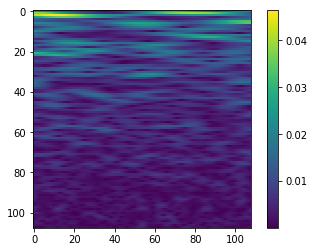

(2726, 1, 108, 108)


In [10]:
for spectrogram_ in glob_spectrogram:
    
    spectrogram = np.load(spectrogram_)
    print(np.shape(spectrogram))
    print(np.shape(spectrogram[:,:]))
    cnn_inputs = np.array(list(zip([spectrogram[:,i:-108+i:27] for i in range(108)])))
    print(np.shape(cnn_inputs))
    cnn_inputs = np.swapaxes(cnn_inputs,0,3)
    print(np.shape(cnn_inputs))
    cnn_inputs = [cnn_input for cnn_input in cnn_inputs]
    print(np.shape(cnn_inputs[1]))
    plt.imshow(cnn_inputs[7][0,:,:])
    plt.colorbar()
    plt.show()
    
print(np.shape(cnn_inputs))


(2726, 1, 108, 108)
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The note

The notes are: C4
The notes are: C4_60_64_66_75_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_67_75_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_63_64
The notes are: C4
The notes are: C4
The notes are: C4_64_71_75_81_82
The notes are: C4
The notes are: C4
The notes are: C4_61_64_66_71_75_81_82
The notes are: C4
The notes are: C4
The notes are: C4_66_71_80_82
The notes are: C4
The notes are: C4
The notes are: C4_82
The notes are: C4
The notes are: C4
The notes are: C4_61_62_75_80_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_75_80_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_61_62_68_83
The notes are: C4
The notes are: C4
The notes are: C4
T

The notes are: C4_75_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_73_75_81_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_65_66_67_75_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_75
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64
The notes are: C4
The notes are: C4
The notes are: C4_64_66_75_80_82
The notes are: C4
The notes are: C4
The notes are: C4_64_66_75_80
The notes are: C4
The notes are: C4
The notes are: C4_66_75_82
The notes are: C4
The notes are: C4
The notes are: C4_64_75_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_75_81_83
The notes are: C4
The notes are: C4
The notes are: C4_64_66_75
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_66_75_83
The notes are: C4
The notes are: C4
The notes are: C

The notes are: C4
The notes are: C4_60_77_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_80_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_61_67_79_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_66_67_75_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_64_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_62_66_75_80
The notes are: C4
The notes are: C4
The notes are: C4_60_62_66
The notes are: C4
The notes are: C4
The notes are: C4_60_66_75_82
The notes are: C4
The notes are: C4
The notes are: C4_60_66_77_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_61_81_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_61_66_81
The notes are: C4
The notes are

The notes are: C4
The notes are: C4_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_66_67
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_67_69
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_61_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_66_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_65_66_67
The notes are: C4
The notes are: C4
The notes are: C4_64_70_75
The notes are: C4
The notes are: C4
The notes are: C4_64_65_82
The notes are: C4
The notes are: C4
The notes are: C4_61_64_65_66_69
The notes are: C4
The notes are: C4
The notes are: C4_64_65_66_67_69_73_81
The notes are: C4
The notes are: C4
The notes are: C4_65_67_69
The notes are: C4
The notes are: C4
The notes are: C4_66
The notes are: C4
The 

The notes are: C4_81
The notes are: C4
The notes are: C4
The notes are: C4_65_67_75_81
The notes are: C4
The notes are: C4
The notes are: C4_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_66_75_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_66_67_73_75_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_65_67_75_83
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_70_79_83
The notes are: C4
The notes are: C4
The notes are: C4_75
The notes are: C4
The notes are: C4_60_62_64_66_75_80
The notes are: C4
The notes are: C4
The notes are: C4_66_75_82
The notes are: C4
The notes are: C4
The notes are: C4_65_66_75_82
The notes are: C4
The notes are: C4
The notes are: C4_64_65_75_81_82
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_65_75_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_81_83
T

The notes are: C4
The notes are: C4
The notes are: C4_79
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_70_77_78
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_79
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_70
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_64_70
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_70
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_66_78_81
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_60_66
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4
The notes are: C4_66_79_81
The notes are: C4
The notes are: C4
The notes are: C4_62
The notes are: C4
The notes are: C4
The notes are: C4
The not

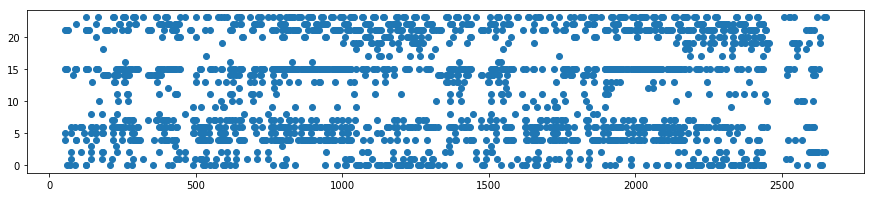

In [11]:
plt.figure(figsize=(15,3))
lstm_memory = np.zeros((1,20,24))
predicted_score = []

print(np.shape(cnn_inputs))
for i, cnn_input in enumerate(cnn_inputs):
    
#     print(np.shape(cnn_input))
#     print(np.shape(lstm_input))
#     give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))
#     print(lstm_input[-1,-1])
#     print(result)
    result = give_prediction(classifier, lstm_memory, cnn_input.reshape((1,108,108,1)))
    lstm_memory[0,:-1] = np.copy(lstm_memory[0,1:])
    lstm_memory[0,-1] = np.copy(result)
    for j, note in enumerate(result[0]):
        if note != 0:
            predicted_score.append([i,j])

predicted_score = np.transpose(predicted_score)
plt.scatter(predicted_score[0], predicted_score[1], marker='o')            
plt.show()